In [ ]:
# | hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
# | default_exp inspect.any_model

# Any Model

> Inspector functionality for any model

In [ ]:
# | export
from typing import Optional
import warnings

import pandas as pd
from fastcore.basics import basic_repr, store_attr
from matplotlib.axes import Axes
from numpy.typing import NDArray
from sklearn.base import BaseEstimator
import sklearn.inspection
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted

from model_inspector.delegate import delegates
from model_inspector.explore import plot_column_clusters, show_correlation

In [ ]:
# | export
class _Inspector:
    """Model inspector base class.

    Users should use `get_inspector` to generate appropriate
    `_Inspector` objects rather than instantiating this class or its
    subclasses directly.
    """

    def __init__(
        self,
        # We aim to support estimators with `scikit-learn`-compatible
        # interfaces from popular libraries such as `xgboost` and
        # `catboost` even if they do not inherit from `BaseEstimator`,
        # but I do not know of a simple way to include them in this type
        # hint without adding those libraries as dependencies, which I
        # would like to avoid if possible.
        model: BaseEstimator,
        X: pd.DataFrame,
        y: pd.Series,
    ):
        check_is_fitted(model)
        check_X_y(X, y)
        self._check_cols(model, X)

        store_attr()

    __repr__ = basic_repr(["model"])

    def _check_cols(self, model, X):
        try:
            if not model.feature_names_in_.equals(X.columns):
                raise ValueError("`model.feature_names_in_` should match `X.columns`")
        except AttributeError:
            warnings.warn(
                """`model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                """
            )
            try:
                if not model.n_features_in_ == len(X.columns):
                    raise ValueError(
                        "`model.n_features_in_` must equal `len(X.columns)`."
                    )
            except AttributeError:
                warnings.warn(
                    """`model` does not have the `n_features_in_`
                    attribute, so we cannot confirm that `X` has as many
                    columns as `model` has features. Proceed at your own
                    risk!"""
                )

    @delegates(sklearn.inspection.PartialDependenceDisplay.from_estimator)
    def plot_partial_dependence(self, **kwargs) -> NDArray[Axes]:
        """Plot partial dependence."""
        return sklearn.inspection.PartialDependenceDisplay.from_estimator(
            estimator=self.model, X=self.X, **kwargs
        ).axes_

    @delegates(sklearn.inspection.permutation_importance)
    def permutation_importance(
        self,
        sort: bool = True,
        **kwargs,
    ) -> pd.Series:
        """Calculate permutation importance.

        Parameters:

        - `sort`: Sort features by decreasing importance.
        """
        if kwargs is None:
            kwargs = {}
        kwargs = {**{"n_jobs": -1}, **kwargs}

        importances = pd.Series(
            sklearn.inspection.permutation_importance(
                self.model, self.X, self.y, **kwargs
            )["importances_mean"],
            index=self.X.columns,
        )
        if sort:
            importances = importances.sort_values(ascending=False)
        return importances

    def plot_permutation_importance(
        self,
        ax: Optional[Axes] = None,
        importance_kwargs: Optional[dict] = None,
        plot_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot a correlation matrix for `self.X` and `self.y`.

        Parameters:

        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `importance_kwargs`: kwargs to pass to
        `sklearn.inspection.permutation_importance`
        - `plot_kwargs`: kwargs to pass to `pd.Series.plot.barh`
        """
        if importance_kwargs is None:
            importance_kwargs = {}
        # reversing the order to compensate for `barh` reversing it
        importance = self.permutation_importance(**importance_kwargs).iloc[::-1]

        if plot_kwargs is None:
            plot_kwargs = {}
        ax = importance.plot.barh(**plot_kwargs)
        ax.set(title="Feature importances")
        ax.bar_label(ax.containers[0], fmt="%.2f")
        # extending plot on the right to accommodate labels
        ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1] * 1.05))
        return ax

    @delegates(show_correlation)
    def show_correlation(self, **kwargs):
        """Show a correlation matrix for `self.X` and `self.y`.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        """
        return show_correlation(
            df=pd.concat((self.X, self.y), axis="columns"),
            **kwargs,
        )

    @delegates(plot_column_clusters)
    def plot_feature_clusters(self, **kwargs) -> Axes:
        """Plot a dendrogram based on feature correlations.

        Parameters:

        - `corr_method`: Method of correlation to pass to `df.corr()`
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """
        return plot_column_clusters(self.X, **kwargs)

    @property
    def methods(self):
        """Show available methods."""
        return [
            i
            for i in dir(self)
            if not i.startswith("__")
            and i not in self.__stored_args__
            and i != "methods"
        ]

In [ ]:
# | export
_all_ = ["_Inspector"]

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor

from model_inspector import get_inspector

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(
    RandomForestRegressor().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

/Users/greg.gandenberger/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(


In [ ]:
# | hide
from nbdev import show_doc
import sklearn.datasets
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR

In [ ]:
show_doc(_Inspector.methods, name="_Inspector.methods")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L164){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.methods

>      _Inspector.methods ()

Show available methods.

In [ ]:
inspector.methods

['_check_cols',
 'permutation_importance',
 'plot_feature_clusters',
 'plot_partial_dependence',
 'plot_permutation_importance',
 'plot_pred_vs_act',
 'plot_residuals',
 'show_correlation']

In [ ]:
show_doc(_Inspector.permutation_importance)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L84){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.permutation_importance

>      _Inspector.permutation_importance (sort:bool=True, scoring=None,
>                                         n_repeats=5, n_jobs=None,
>                                         random_state=None, sample_weight=None,
>                                         max_samples=1.0)

Calculate permutation importance.

Parameters:

- `sort`: Sort features by decreasing importance.

Remaining parameters are passed to `sklearn.inspection._permutation_importance.permutation_importance`.

In [ ]:
inspector.permutation_importance()

bmi    0.482974
s5     0.472974
bp     0.137960
s6     0.092853
s3     0.088472
age    0.077993
s2     0.067045
s1     0.051492
sex    0.023468
s4     0.022805
dtype: float64

In [ ]:
show_doc(_Inspector.plot_partial_dependence)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L77){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.plot_partial_dependence

>      _Inspector.plot_partial_dependence (categorical_features=None,
>                                          feature_names=None, target=None,
>                                          response_method='auto', n_cols=3,
>                                          grid_resolution=100,
>                                          percentiles=(0.05, 0.95),
>                                          method='auto', n_jobs=None,
>                                          verbose=0, line_kw=None,
>                                          ice_lines_kw=None, pd_line_kw=None,
>                                          contour_kw=None, ax=None,
>                                          kind='average', centered=False,
>                                          subsample=1000, random_state=None)

Plot partial dependence.

Remaining parameters are passed to `sklearn.inspection._plot.partial_dependence.from_estimator`.

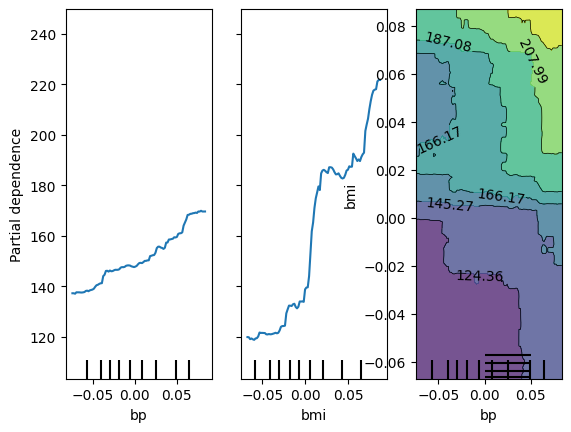

In [ ]:
axes = inspector.plot_partial_dependence(features=["bp", "bmi", ["bp", "bmi"]])

In [ ]:
show_doc(_Inspector.plot_feature_clusters)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L152){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.plot_feature_clusters

>      _Inspector.plot_feature_clusters (corr_method:str='spearman',
>                                        ax:matplotlib.axes._axes.Axes=None,
>                                        p=30, truncate_mode=None,
>                                        color_threshold=None, get_leaves=True,
>                                        orientation='top', labels=None,
>                                        count_sort=False, distance_sort=False,
>                                        show_leaf_counts=True, no_plot=False,
>                                        no_labels=False, leaf_font_size=None,
>                                        leaf_rotation=None,
>                                        leaf_label_func=None,
>                                        show_contracted=False,
>                                        link_color_func=None,
>                                        above_threshold_color='C0')

Plot a dendrogram based on feature correlations.

Parameters:

- `corr_method`: Method of correlation to pass to `df.corr()`
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

Remaining parameters are passed to `model_inspector.explore.plot_column_clusters`.

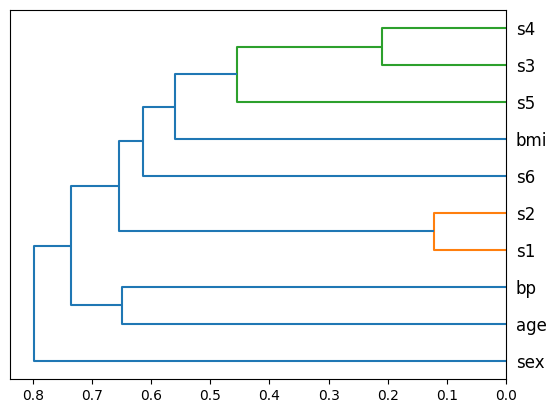

In [ ]:
ax = inspector.plot_feature_clusters()

In [ ]:
show_doc(_Inspector.plot_permutation_importance)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L109){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.plot_permutation_importance

>      _Inspector.plot_permutation_importance
>                                              (ax:Optional[matplotlib.axes._axe
>                                              s.Axes]=None, importance_kwargs:O
>                                              ptional[dict]=None,
>                                              plot_kwargs:Optional[dict]=None)

Plot a correlation matrix for `self.X` and `self.y`.

Parameters:

- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `importance_kwargs`: kwargs to pass to
`sklearn.inspection.permutation_importance`
- `plot_kwargs`: kwargs to pass to `pd.Series.plot.barh`

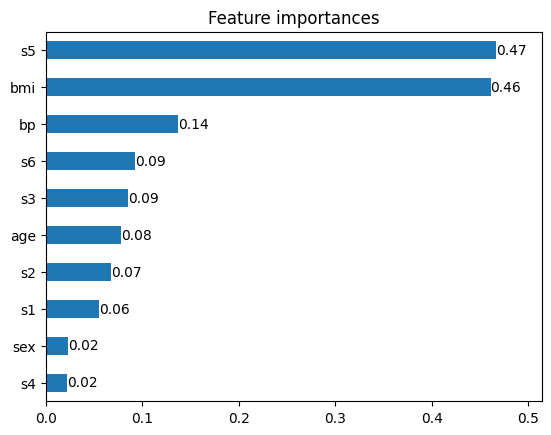

In [ ]:
ax = inspector.plot_permutation_importance()

In [ ]:
show_doc(_Inspector.show_correlation)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/any_model.py#L140){target="_blank" style="float:right; font-size:smaller"}

### _Inspector.show_correlation

>      _Inspector.show_correlation (method='pearson', cmap='PuBu', low:float=0,
>                                   high:float=0, axis:Axis|None=0,
>                                   subset:Subset|None=None,
>                                   text_color_threshold:float=0.408,
>                                   vmin:float|None=None, vmax:float|None=None,
>                                   gmap:Sequence|None=None)

Show a correlation matrix for `self.X` and `self.y`.

If output is not rendering properly when you reopen a notebook,
make sure the notebook is trusted.

Remaining parameters are passed to `model_inspector.explore.show_correlation`.

In [ ]:
inspector.show_correlation()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.00,0.17,0.19,0.34,0.26,0.22,-0.08,0.20,0.27,0.30,0.19
sex,0.17,1.00,0.09,0.24,0.04,0.14,-0.38,0.33,0.15,0.21,0.04
bmi,0.19,0.09,1.00,0.40,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
bp,0.34,0.24,0.40,1.00,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
s1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33,0.21
s2,0.22,0.14,0.26,0.19,0.90,1.00,-0.20,0.66,0.32,0.29,0.17
s3,-0.08,-0.38,-0.37,-0.18,0.05,-0.20,1.00,-0.74,-0.40,-0.27,-0.39
s4,0.20,0.33,0.41,0.26,0.54,0.66,-0.74,1.00,0.62,0.42,0.43
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.40,0.62,1.00,0.46,0.57
s6,0.30,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1.00,0.38


In [ ]:
# | hide
REGRESSORS = [KNeighborsRegressor, SVR, RandomForestRegressor, LinearRegression, Ridge]
CLASSIFIERS = [
    MLPClassifier,
    KNeighborsClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    LogisticRegression,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    SVC,
]
MODELS = REGRESSORS + CLASSIFIERS
X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        model = model_class().fit(X_iris, y_iris)
        for method in [
            "methods",
            "permutation_importance",
            "plot_partial_dependence",
            "plot_feature_clusters",
            "plot_permutation_importance",
            "show_correlation",
        ]:
            assert hasattr(get_inspector(model, X_iris, y_iris), method)